#Лабораторная работа по курсу

#Загружаем данные

In [119]:
# скачиваем данные
!wget 'https://archive.ics.uci.edu/static/public/40/flags.zip'

--2024-11-27 10:42:29--  https://archive.ics.uci.edu/static/public/40/flags.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘flags.zip.1’

flags.zip.1             [ <=>                ]   5.72K  --.-KB/s    in 0s      

2024-11-27 10:42:29 (85.3 MB/s) - ‘flags.zip.1’ saved [5862]



In [120]:
import zipfile

# Путь к zip-архиву
archive_path = '/content/flags.zip'

# Распаковываем zip-архив
with zipfile.ZipFile(archive_path, 'r') as zip_ref:
    zip_ref.extractall()

In [121]:
import pandas as pd
import numpy as np

cols = ['name','landmass','zone','area','population','language','religion','bars','stripes',
       'colours','red','green','blue','gold','white','black','orange','mainhue','circles',
       'crosses','saltires','quarters','sunstars','crescent','triangle','icon','animate',
       'text','topleft','botright']

# загружаю датасет
data = pd.read_csv('/content/flag.data', header=None, names=cols)
data.head()

,name,landmass,zone,area,population,language,religion,bars,stripes,colours,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
0,Afghanistan,5,1,648,16,10,2,0,3,5,...,0,0,1,0,0,1,0,0,black,green
1,Albania,3,1,29,3,6,6,0,0,3,...,0,0,1,0,0,0,1,0,red,red
2,Algeria,4,1,2388,20,8,2,2,0,3,...,0,0,1,1,0,0,0,0,green,white
3,American-Samoa,6,3,0,0,1,1,0,0,5,...,0,0,0,0,1,1,1,0,blue,red
4,Andorra,3,1,0,0,6,0,3,0,3,...,0,0,0,0,0,0,0,0,blue,red


#Анализ данных

In [122]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        194 non-null    object
 1   landmass    194 non-null    int64 
 2   zone        194 non-null    int64 
 3   area        194 non-null    int64 
 4   population  194 non-null    int64 
 5   language    194 non-null    int64 
 6   religion    194 non-null    int64 
 7   bars        194 non-null    int64 
 8   stripes     194 non-null    int64 
 9   colours     194 non-null    int64 
 10  red         194 non-null    int64 
 11  green       194 non-null    int64 
 12  blue        194 non-null    int64 
 13  gold        194 non-null    int64 
 14  white       194 non-null    int64 
 15  black       194 non-null    int64 
 16  orange      194 non-null    int64 
 17  mainhue     194 non-null    object
 18  circles     194 non-null    int64 
 19  crosses     194 non-null    int64 
 20  saltires  

In [123]:
black_list = ['name'] # имя страны не рассматриваем
categoricals = ['landmass','zone','language','mainhue','topleft','botright']
dummies = ['red','green','blue','gold','white','black','orange','crescent','triangle','icon','animate','text']
continious = ['area', 'population', 'bars', 'stripes', 'colours','circles', 'crosses', 'saltires', 'quarters', 'sunstars']
target = 'religion'

In [124]:
data[continious].describe()

,area,population,bars,stripes,colours,circles,crosses,saltires,quarters,sunstars
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,700.046392,23.268041,0.453608,1.551546,3.463918,0.170103,0.149485,0.092784,0.149485,1.386598
std,2170.927932,91.934085,1.038339,2.328005,1.300154,0.463075,0.385387,0.290879,0.435860,4.396186
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,111.000000,4.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,471.250000,14.000000,0.000000,3.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,22402.000000,1008.000000,5.000000,14.000000,8.000000,4.000000,2.000000,1.000000,4.000000,50.000000


In [125]:
data[data.area == 0]

,name,landmass,zone,area,population,language,religion,bars,stripes,colours,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
3,American-Samoa,6,3,0,0,1,1,0,0,5,...,0,0,0,0,1,1,1,0,blue,red
4,Andorra,3,1,0,0,6,0,3,0,3,...,0,0,0,0,0,0,0,0,blue,red
6,Anguilla,1,4,0,0,1,1,0,1,3,...,0,0,0,0,0,0,1,0,white,blue
7,Antigua-Barbuda,1,4,0,0,1,1,0,1,5,...,0,0,1,0,1,0,0,0,black,red
15,Barbados,1,4,0,0,1,1,3,0,3,...,0,0,0,0,0,1,0,0,blue,blue
19,Bermuda,1,4,0,0,1,1,0,0,6,...,1,1,0,0,0,1,1,0,white,red
24,British-Virgin-Isles,1,4,0,0,1,1,0,0,6,...,1,1,0,0,0,1,1,1,white,blue
33,Cayman-Islands,1,4,0,0,1,1,0,0,6,...,1,1,4,0,0,1,1,1,white,blue
41,Cook-Islands,6,3,0,0,1,1,0,0,4,...,1,1,15,0,0,0,0,0,white,blue
48,Dominica,1,4,0,0,1,1,0,0,6,...,0,0,10,0,0,0,1,0,green,green


In [126]:
data[data.population==0]

,name,landmass,zone,area,population,language,religion,bars,stripes,colours,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
3,American-Samoa,6,3,0,0,1,1,0,0,5,...,0,0,0,0,1,1,1,0,blue,red
4,Andorra,3,1,0,0,6,0,3,0,3,...,0,0,0,0,0,0,0,0,blue,red
6,Anguilla,1,4,0,0,1,1,0,1,3,...,0,0,0,0,0,0,1,0,white,blue
7,Antigua-Barbuda,1,4,0,0,1,1,0,1,5,...,0,0,1,0,1,0,0,0,black,red
12,Bahamas,1,4,19,0,1,1,0,3,3,...,0,0,0,0,1,0,0,0,blue,blue
13,Bahrain,5,1,1,0,8,2,0,0,2,...,0,0,0,0,0,0,0,0,white,red
15,Barbados,1,4,0,0,1,1,3,0,3,...,0,0,0,0,0,1,0,0,blue,blue
17,Belize,1,4,23,0,1,1,0,2,8,...,0,0,0,0,0,1,1,1,red,red
19,Bermuda,1,4,0,0,1,1,0,0,6,...,1,1,0,0,0,1,1,0,white,red
24,British-Virgin-Isles,1,4,0,0,1,1,0,0,6,...,1,1,0,0,0,1,1,1,white,blue


In [127]:
data[dummies].agg(['min', 'max', 'nunique', 'mean'])

,red,green,blue,gold,white,black,orange,crescent,triangle,icon,animate,text
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
nunique,2.00000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,0.78866,0.469072,0.510309,0.469072,0.752577,0.268041,0.134021,0.056701,0.139175,0.252577,0.201031,0.082474


In [128]:
dummies

['red',
 'green',
 'blue',
 'gold',
 'white',
 'black',
 'orange',
 'crescent',
 'triangle',
 'icon',
 'animate',
 'text']

In [129]:
data[continious]

,area,population,bars,stripes,colours,circles,crosses,saltires,quarters,sunstars
0,648,16,0,3,5,0,0,0,0,1
1,29,3,0,0,3,0,0,0,0,1
2,2388,20,2,0,3,0,0,0,0,1
3,0,0,0,0,5,0,0,0,0,0
4,0,0,3,0,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
189,3,0,0,0,3,0,0,0,1,5
190,256,22,0,3,4,0,0,0,0,1
191,905,28,0,0,4,1,0,0,0,0
192,753,6,3,0,4,0,0,0,0,0


In [130]:
y = data[target]
y.head(2)

,religion
0,2
1,6


In [131]:
y.value_counts()

,count
religion,
1,60
0,40
2,36
5,27
6,15
3,8
4,4
7,4


In [132]:
def union_classes(x):
    if x in [3,4,7]:
        return 3
    elif x==6:
        return 5
    elif x==5:
        return 4
    else:
        return x

In [133]:
data['religion'] = data['religion'].apply(union_classes)

In [134]:
y = data['religion']
y.value_counts()

,count
religion,
1,60
0,40
2,36
4,27
3,16
5,15


In [135]:
X = pd.concat([data[continious], data[dummies],
               pd.get_dummies(data[categoricals])],
               axis=1
             )
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 48 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   area             194 non-null    int64
 1   population       194 non-null    int64
 2   bars             194 non-null    int64
 3   stripes          194 non-null    int64
 4   colours          194 non-null    int64
 5   circles          194 non-null    int64
 6   crosses          194 non-null    int64
 7   saltires         194 non-null    int64
 8   quarters         194 non-null    int64
 9   sunstars         194 non-null    int64
 10  red              194 non-null    int64
 11  green            194 non-null    int64
 12  blue             194 non-null    int64
 13  gold             194 non-null    int64
 14  white            194 non-null    int64
 15  black            194 non-null    int64
 16  orange           194 non-null    int64
 17  crescent         194 non-null    int64
 18  triangle  

#Подготовим данные

In [136]:
y.value_counts()

,count
religion,
1,60
0,40
2,36
4,27
3,16
5,15


In [137]:
# разобрьем данные на тест и трейн
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42
                                                   )

#RandomForestClassifier

In [138]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

In [139]:
# построим модель RandomForestClassifier по умолчанию
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

In [140]:
# построим модель StratifiedKFold
skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

In [141]:
score_on_train = 0
for trn_idx,tst_idx in skf.split(X_train, y_train):
    X_train_fold, y_train_fold = X.iloc[trn_idx], y.iloc[trn_idx]
    X_test_fold, y_test_fold = X.iloc[tst_idx], y.iloc[tst_idx]
    rfc.fit(X_train_fold, y_train_fold)
    score_on_train += rfc.score(X_test_fold, y_test_fold)

rfc.fit(X_train, y_train)
print(f'score_on_train={score_on_train/3 :.3f}')
print(f'score_on_test ={rfc.score(X_test, y_test) :.3f}')

score_on_train=0.665
score_on_test =0.641


Посмотрим на важность признаков

In [142]:
# посмотрим на важность признаков
importances = rfc.feature_importances_
importances[:5]

array([0.0848725 , 0.08851644, 0.01368203, 0.0352198 , 0.03355166])

In [307]:
# построим список наших признаков
feature_list = list(X_train)
feature_list[:5]

['area', 'population', 'bars', 'stripes', 'colours']

In [308]:
# соберем df из feature и importance
feature_importance = pd.DataFrame({'feature':feature_list, 'importance':importances})
feature_importance.head(2)

,feature,importance
0,area,0.122694
1,population,0.119519


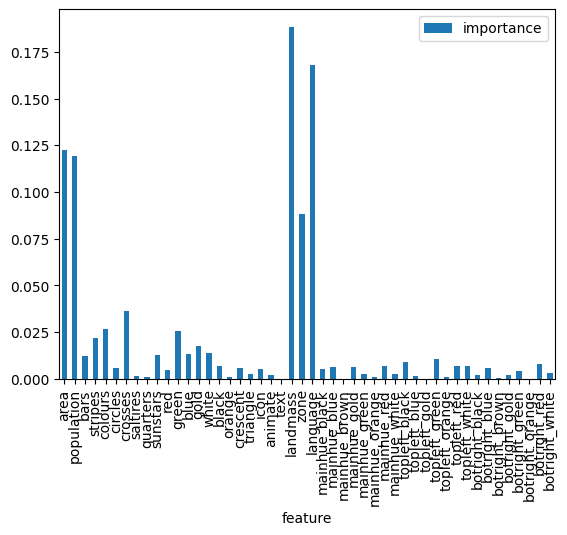

In [309]:
# посмотрим
import matplotlib.pyplot as plt

feature_importance.plot(x='feature',
                        y='importance',
                        kind='bar'
                       )
plt.show()

#Сбалансируем нашу выборку

Используем SMOTE

In [146]:
!pip install imbalanced-learn

In [147]:
# разобрьем данные на тест и трейн
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42
                                                   )

In [148]:
y.value_counts()

,count
religion,
1,60
0,40
2,36
4,27
3,16
5,15


In [149]:
y_train.value_counts()

,count
religion,
1,48
0,32
2,29
4,21
3,13
5,12


In [150]:
from imblearn.over_sampling import SMOTE

In [151]:
counter = {0: 32, 1: 48, 2: 29, 3: 29, 4: 29, 5: 29}

In [152]:
sm = SMOTE(
           sampling_strategy=counter, # стратегия выборки. 'auto' означает увеличение
                                      # меньшего класса до размера большинственного.
           random_state=42,           # зерно для генератора случайных чисел.
           k_neighbors=5,             # количество ближайших соседей для создания
                                      # синтетических примеров.
           n_jobs=1                   # Количество ядер для параллельной работы.
                                      # -1 означает использование всех доступных ядер.
          )

In [153]:
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [154]:
y_train_sm.value_counts()

,count
religion,
1,48
0,32
4,29
2,29
5,29
3,29


In [155]:
# построим модель RandomForestClassifier по умолчанию
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

In [156]:
# обучим
rfc_sm = rfc.fit(X_train_sm, y_train_sm)
rfc_sm

RandomForestClassifier(n_jobs=-1, random_state=42)

In [157]:
# получим метрики
score_on_train = rfc_sm.score(X_train_sm, y_train_sm)
score_on_test = rfc_sm.score(X_test, y_test)

print(f'score_on_train={score_on_train :.3f}')
print(f'score_on_test ={score_on_test :.3f}')

score_on_train=1.000
score_on_test =0.692


In [158]:
# посмотрим на важность признаков
importances = rfc.feature_importances_
importances[:5]

array([0.09419659, 0.09511362, 0.01678497, 0.03853547, 0.03465648])

In [310]:
# построим список наших признаков
feature_list = list(X_train_sm)
feature_list[:5]

['area', 'population', 'bars', 'stripes', 'colours']

In [311]:
# соберем df из feature и importance
feature_importance = pd.DataFrame({'feature':feature_list, 'importance':importances})
feature_importance.head(2)

,feature,importance
0,area,0.122694
1,population,0.119519


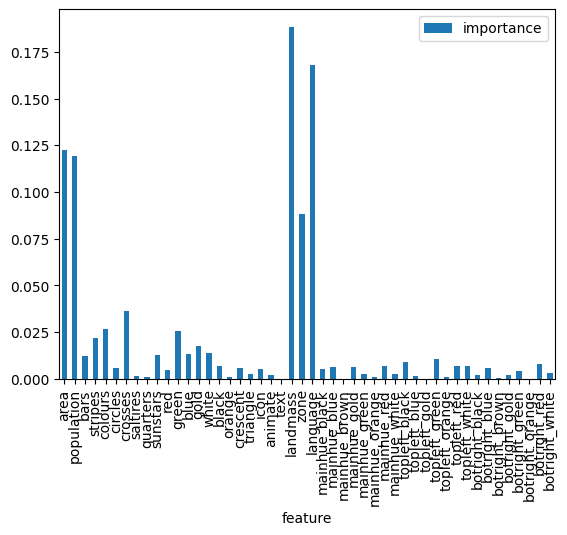

In [312]:
# посмотрим
import matplotlib.pyplot as plt

feature_importance.plot(x='feature',
                        y='importance',
                        kind='bar'
                       )
plt.show()

Подберем лучшие параметры для RandomForestClassifier

In [162]:
from sklearn.model_selection import GridSearchCV

In [295]:
# зададим возможные параметры
param_grid = {'max_depth': [9, 12, 15],
              'max_features': [None, 'sqrt', 'log2'],
              #'max_leaf_nodes': [6, 9, 12],
              #'min_samples_leaf': [6, 9, 12],
              #'min_samples_split': [3, 6],
              'n_estimators': [25, 50, 100]
             }

In [296]:
# построим модель RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

In [297]:
# построим GridSearchCV модель
rfc_grid = GridSearchCV(rfc, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

In [298]:
# обучим
rfc_grid.fit(X_train_sm, y_train_sm)
rfc_grid

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [9, 12, 15],
                         'max_features': [None, 'sqrt', 'log2'],
                         'n_estimators': [10, 25, 50, 100]},
             verbose=True)

In [299]:
# получим наши лучшие параметры
best_params = rfc_grid.best_params_
best_params

{'max_depth': 9, 'max_features': None, 'n_estimators': 50}

In [300]:
# получим и обучим нашу лучшую модель
rfc_sm_best = rfc_grid.best_estimator_
rfc_sm_best.fit(X_train_sm, y_train_sm)
rfc_sm_best

RandomForestClassifier(max_depth=9, max_features=None, n_estimators=50,
                       n_jobs=-1, random_state=42)

In [302]:
# получим метрики
score_on_train = rfc_sm_best.score(X_train_sm, y_train_sm)
score_on_test = rfc_sm_best.score(X_test, y_test)

print(f'score_on_train={score_on_train :.3f}')
print(f'score_on_test ={score_on_test :.3f}')

score_on_train=1.000
score_on_test =0.744


In [306]:
# посмотрим на важность признаков
importances = rfc_sm_best.feature_importances_
importances[:5]

array([0.12269416, 0.1195185 , 0.01235906, 0.02189209, 0.02652807])

In [313]:
# построим список наших признаков
feature_list = list(X_train_sm)
feature_list[:5]

['area', 'population', 'bars', 'stripes', 'colours']

In [314]:
# соберем df из feature и importance
feature_importance = pd.DataFrame({'feature':feature_list, 'importance':importances})
feature_importance.head()

,feature,importance
0,area,0.122694
1,population,0.119519
2,bars,0.012359
3,stripes,0.021892
4,colours,0.026528


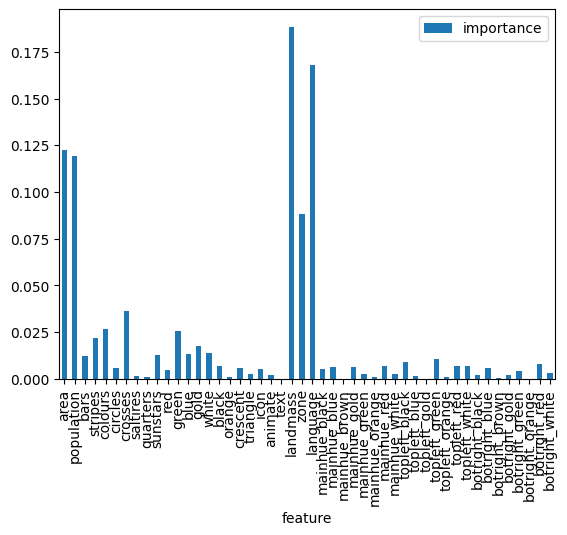

In [315]:
# посмотрим
import matplotlib.pyplot as plt

feature_importance.plot(x='feature',
                        y='importance',
                        kind='bar'
                       )
plt.show()

#Определение избыточных признаков

Добавим рандомный признак

In [320]:
# рандомный признак random_feauture
X_train_sm_rn = X_train_sm.copy()
X_train_sm_rn['random_feauture'] = np.random.random(X_train_sm.shape[0])
X_train_sm_rn.head(2)

,area,population,bars,stripes,colours,circles,crosses,saltires,quarters,sunstars,...,topleft_white,botright_black,botright_blue,botright_brown,botright_gold,botright_green,botright_orange,botright_red,botright_white,random_feauture
0,9363,231,0,13,3,0,0,0,1,50,...,False,False,False,False,False,False,False,True,False,0.678985
1,28,0,0,3,4,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,0.837307


In [321]:
# зададим возможные параметры
param_grid = {'max_depth': [9, 12, 15],
              'max_features': [None, 'sqrt', 'log2'],
              #'max_leaf_nodes': [6, 9, 12],
              #'min_samples_leaf': [6, 9, 12],
              #'min_samples_split': [3, 6],
              'n_estimators': [25, 50, 100]
             }

In [322]:
# построим модель RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

In [323]:
# построим GridSearchCV модель
rfc_grid = GridSearchCV(rfc, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

In [324]:
# обучим
rfc_grid.fit(X_train_sm_rn, y_train_sm)
rfc_grid

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [9, 12, 15],
                         'max_features': [None, 'sqrt', 'log2'],
                         'n_estimators': [25, 50, 100]},
             verbose=True)

In [ ]:
# получим наши лучшие параметры
best_params = rfc_grid.best_params_
best_params

In [325]:
# получим и обучим нашу лучшую модель
rfc_sm_rn_best = rfc_grid.best_estimator_
rfc_sm_rn_best.fit(X_train_sm_rn, y_train_sm)
rfc_sm_rn_best

RandomForestClassifier(max_depth=9, n_jobs=-1, random_state=42)

In [328]:
# получим метрики
score_on_train = rfc_sm_rn_best.score(X_train_sm_rn, y_train_sm)
#score_on_test = rfc_sm_rn_best.score(X_test, y_test)

print(f'score_on_train={score_on_train :.3f}')

score_on_train=1.000


In [ ]:
cols = ['language', 'landmass', 'religion']
df_ = data[cols]
df_.head(2)

In [ ]:
df_0 = df_[df_['religion'] ==0].drop('religion', axis='columns')
df_1 = df_[df_['religion'] ==1].drop('religion', axis='columns')
df_2 = df_[df_['religion'] ==2].drop('religion', axis='columns')
df_3 = df_[df_['religion'] ==3].drop('religion', axis='columns')
df_4 = df_[df_['religion'] ==4].drop('religion', axis='columns')
df_5 = df_[df_['religion'] ==5].drop('religion', axis='columns')

In [ ]:
x_0 = df_0['language'].to_numpy()
y_0 = df_0['landmass'].to_numpy()

x_1 = df_1['language'].to_numpy()
y_1 = df_1['landmass'].to_numpy()

x_2 = df_2['language'].to_numpy()
y_2 = df_2['landmass'].to_numpy()

In [ ]:
plt.scatter(x_0, y_0, color='r')
plt.scatter(x_1, y_1, color='b')
#plt.scatter(x_2, y_2, color='g')
plt.show()

Определение избыточной выборки

In [ ]:
# оставим только самые значимые признаки
cols = ['area', 'landmass', 'zone', 'language']

In [ ]:
# зададим возможные параметры
param_grid = {'max_depth': [4, 5],
              'max_features': ['sqrt', 'log2', None],
              'max_leaf_nodes': [9, 12, 15],
              'min_samples_leaf': [9],
              'min_samples_split': [7],
              'n_estimators': [150, 200, 250]
             }

In [ ]:
# построим модель RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

In [ ]:
# построим GridSearchCV модель
rfc_grid = GridSearchCV(rfc, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

In [ ]:
# обучим
rfc_grid.fit(X_train[cols], y_train)
rfc_grid

In [ ]:
# получим наши лучшие параметры
best_params = rfc_grid.best_params_
best_params

In [ ]:
# получим и обучим нашу лучшую модель на меньшем числе признаков
rfc_best = rfc_grid.best_estimator_
rfc_best.fit(X_train[cols], y_train)
rfc_best

In [ ]:
# получим метрики
score_on_train = rfc_best.score(X_train[cols], y_train)
score_on_test = rfc_best.score(X_test[cols], y_test)

print(f'score_on_train={score_on_train :.3f}')
print(f'score_on_test ={score_on_test :.3f}')

Добавим рандомный признак

In [ ]:
# рандомный признак random_feauture
X_random = X.copy()
X_random['random_feauture'] = np.random.random(X.shape[0])
X_random.head(2)

In [ ]:
# разобрьем данные на тест и трейн
from sklearn.model_selection import train_test_split

X_train_random, X_test_random, y_train, y_test = train_test_split(X_random, y,
                                                                  test_size=0.2,
                                                                  stratify=y,
                                                                  random_state=42
                                                                 )

In [ ]:
# зададим возможные параметры
param_grid = {'max_depth': [3, 6, 9],
              'max_features': ['sqrt', 'log2', None],
              'max_leaf_nodes': [10, 15, 20],
              'min_samples_leaf': [2, 3, 6],
              'min_samples_split': [6, 8],
              'n_estimators': [50, 100]
             }

In [ ]:
# построим модель RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

In [ ]:
# построим GridSearchCV модель
rfc_grid = GridSearchCV(rfc, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

In [ ]:
# обучим
rfc_grid.fit(X_train_random, y_train)
rfc_grid

In [ ]:
# получим наши лучшие параметры
best_params = rfc_grid.best_params_
best_params

In [ ]:
# получим и обучим нашу лучшую модель на меньшем числе признаков
rfc_best = rfc_grid.best_estimator_
rfc_best.fit(X_train_random, y_train)
rfc_best

In [ ]:
# получим метрики
score_on_train = rfc_best.score(X_train_random, y_train)
score_on_test = rfc_best.score(X_test_random, y_test)

print(f'score_on_train={score_on_train :.3f}')
print(f'score_on_test ={score_on_test :.3f}')

In [ ]:
# посмотрим на важность признаков
importances = rfc_best.feature_importances_
importances

In [ ]:
# построим список наших признаков
feature_list = list(X_train_random.columns)
feature_list[:5]

In [ ]:
# соберем df из feature и importance
feature_importance = pd.DataFrame({'feature':feature_list, 'importance':importances})
feature_importance.head()

In [ ]:
# отсортируем
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance[:6]

In [ ]:
# посмотрим
import matplotlib.pyplot as plt

feature_importance.plot(x='feature',
                        y='importance',
                        kind='bar'
                       )
plt.show()

In [ ]:
# оставим только самые значимые признаки
cols = ['language', 'landmass', 'area', 'zone', 'population']

In [ ]:
# зададим возможные параметры
param_grid = {'max_depth': [6, 9, 12],
              'max_features': ['sqrt', 'log2', None],
              'max_leaf_nodes': [15, 20, 25],
              'min_samples_leaf': [3, 6],
              'min_samples_split': [6, 8, 12],
              'n_estimators': [10, 50]
             }

In [ ]:
# построим модель RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

In [ ]:
# построим GridSearchCV модель
rfc_grid = GridSearchCV(rfc, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

In [ ]:
# обучим
rfc_grid.fit(X_train[cols], y_train)
rfc_grid

In [ ]:
# получим наши лучшие параметры
best_params = rfc_grid.best_params_
best_params

In [ ]:
# получим и обучим нашу лучшую модель на меньшем числе признаков
rfc_best = rfc_grid.best_estimator_
rfc_best.fit(X_train[cols], y_train)
rfc_best


In [ ]:
# получим метрики
score_on_train = rfc_best.score(X_train[cols], y_train)
score_on_test = rfc_best.score(X_test[cols], y_test)

print(f'score_on_train={score_on_train :.3f}')
print(f'score_on_test ={score_on_test :.3f}')

#Попробуем сбалансировать наши данные

Используем SMOTE

In [ ]:
!pip install imbalanced-learn

In [ ]:
# разобрьем данные на тест и трейн
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42
                                                   )

In [ ]:
y.value_counts()

In [ ]:
religions = [0, 1, 2, 3, 4, 5]
for relign in religions:
    print(f'religions={relign}: {sum(y_train == relign)}')

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
sm = SMOTE(
           sampling_strategy='auto',  # стратегия выборки. 'auto' означает увеличение
                                      # меньшего класса до размера большинственного.
           random_state=42,           # зерно для генератора случайных чисел.
           k_neighbors=5,            # количество ближайших соседей для создания
                                      # синтетических примеров.
           n_jobs=1                   # Количество ядер для параллельной работы.
                                      # -1 означает использование всех доступных ядер.
          )

In [ ]:
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [ ]:
for relign in religions:
    print(f'religions={relign}: {sum(y_train_sm == relign)}')

print(X_train_sm.shape, y_train_sm.shape)

In [ ]:
# зададим возможные параметры
param_grid = {'max_depth': [9, 12],
              'max_features': ['sqrt', 'log2', None],
              'max_leaf_nodes': [25, 50, 75],
              'min_samples_leaf': [3, 9],
              'min_samples_split': [6, 9, 12],
              'n_estimators': [200, 500]
             }

In [ ]:
# построим модель RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

In [ ]:
# построим GridSearchCV модель
rfc_grid = GridSearchCV(rfc, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

In [ ]:
# обучим
rfc.fit(X_train_sm, y_train_sm)
rfc

In [ ]:
# получим наши лучшие параметры
best_params = rfc_grid.best_params_
best_params

In [ ]:
# получим и обучим нашу лучшую модель на меньшем числе признаков
rfc_best_sm = rfc_grid.best_estimator_
rfc_best_sm.fit(X_train_sm, y_train_sm)
rfc_best_sm

In [ ]:
# получим метрики
score_on_train = rfc.score(X_train_sm, y_train_sm)
score_on_test = rfc.score(X_test, y_test)

print(f'score_on_train={score_on_train :.3f}')
print(f'score_on_test ={score_on_test :.3f}')

In [ ]:
from imblearn.over_sampling import ADASYN

In [ ]:
adasyn = ADASYN(sampling_strategy='minority')
X_train_ad, y_train_ad = adasyn.fit_resample(X_train, y_train)

In [ ]:
for relign in religions:
    print(f'religions={relign}: {sum(y_train_ad == relign)}')

print(X_train_ad.shape, y_train_ad.shape)

In [ ]:
# зададим возможные параметры
param_grid = {'max_depth': [6, 9, 12],
              'max_features': ['sqrt', 'log2', None],
              'max_leaf_nodes': [5, 15, 20],
              'min_samples_leaf': [3, 6],
              'min_samples_split': [6, 8],
              'n_estimators': [50, 200, 500]
             }

In [ ]:
{'max_depth': 9,
 'max_features': None,
 'max_leaf_nodes': 15,
 'min_samples_leaf': 3,
 'min_samples_split': 6,
 'n_estimators': 50}

In [ ]:
# построим модель RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

In [ ]:
# построим GridSearchCV модель
rfc_grid = GridSearchCV(rfc, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

In [ ]:
# обучим
rfc.fit(X_train_ad, y_train_ad)
rfc

In [ ]:
# получим наши лучшие параметры
best_params = rfc_grid.best_params_
best_params

In [ ]:
# получим и обучим нашу лучшую модель на меньшем числе признаков
rfc_best_ad = rfc_grid.best_estimator_
rfc_best_ad.fit(X_train_ad, y_train_ad)
rfc_best_ad

In [ ]:
# получим метрики
score_on_train = rfc.score(X_train_ad, y_train_ad)
score_on_test = rfc.score(X_test, y_test)

print(f'score_on_train={score_on_train :.3f}')
print(f'score_on_test ={score_on_test :.3f}')

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE

In [ ]:
blsmote = BorderlineSMOTE(sampling_strategy='minority',
                          kind='borderline-1',
                          random_state=42,
                          k_neighbors=11,
                          m_neighbors=11
                         )
X_train_b_sm, y_train_b_sm = blsmote.fit_resample(X_train, y_train)
y_train_b_sm.value_counts()

In [ ]:
y_train.value_counts()

In [ ]:
# зададим возможные параметры
param_grid = {'max_depth': [6, 9, 12],
              'max_features': ['sqrt', 'log2', None],
              'max_leaf_nodes': [15, 20, 25],
              'min_samples_leaf': [3, 6],
              'min_samples_split': [6, 8, 12],
              'n_estimators': [100, 200, 500]
             }

In [ ]:
# построим модель RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

In [ ]:
# построим GridSearchCV модель
rfc_grid = GridSearchCV(rfc, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

In [ ]:
# обучим
rfc.fit(X_train_b_sm, y_train_b_sm)
rfc


In [ ]:
# получим наши лучшие параметры
best_params = rfc_grid.best_params_
best_params

In [ ]:
# получим и обучим нашу лучшую модель на меньшем числе признаков
rfc_best_b_sm = rfc_grid.best_estimator_
rfc_best_b_sm.fit(X_train_b_sm, y_train_b_sm)
rfc_best_b_sm

In [ ]:
# получим метрики
score_on_train = rfc.score(X_train_b_sm, y_train_b_sm)
score_on_test = rfc.score(X_test, y_test)

print(f'score_on_train={score_on_train :.3f}')
print(f'score_on_test ={score_on_test :.3f}')

In [ ]:
from imblearn.combine import SMOTEENN

In [ ]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_train_sm_enn, y_train_sm_enn = smote_enn.fit_resample(X_train, y_train)
y_train_sm_enn.value_counts()